# Actor-critic algorithm 

The actor-critic algorithm is a model-free reinforcement learning algorithm. It shares some similarity with the Policy Iteration algorithm, as it maintains a model of the value function (the critic) and a model of the current policy (the actor), and it improves the actor based on the critic and vice versa. But, of course, the transition and reward functions are not known and updates are performed locally.

There are many possible implementations of an actor-critic algorithm. Here, we focus on the most naive one, where the actor is a stochastic policy and actor updates modify the probability of taking actions.


## Stochastic policy

By taking inspiration of the Policy Iteration algorithm given in the [dynamic programming](dynamic_programming.ipynb) notebook, write a class to handle a stochastic policy, which gives a probability of taking each action in each state
with a table $P[x,u]$.

In [53]:
"write StochasticPolicy class here"

import numpy as np

class StochasticPolicy():
    
    def __init__(self, mdp):
        self.P = np.ones((mdp.observation_space.size, mdp.action_space.size))
        for p in self.P:
            p = p / mdp.action_space.size
    
    def __getitem__(self, state):
        return self.P[state]
    
    def normalize(self, state):
        self.P[state] = self.P[state] / np.sum(self.P[state])
        


## Critic based on the action-value function

By taking inspiration of the Q-learning algorithm given in the [reinforcement learning](reinforcement_learning.ipynb) notebook, write a class to handle a critic represented as a Q-Table.

In [54]:
"write the Q-table Critic class here"

class Critic():
    
    def __init__(self, mdp):
        self.Q = np.zeros((mdp.observation_space.size, mdp.action_space.size))
    
    def __getitem__(self, state):
        return self.Q[state]    
        

## Actor-critic algorithm

Now, write the main ActorCritic class: it contains an agent, an actor, a critic, and two learning rate hyper-parameters $alpha_1$ and $alpha_2$.

Each time the agent takes a step in the environment, it computes a temporal difference error *delta* from the critic, then it updates the critic with

$Q[x,u] = Q[x,u] + alpha_1 * delta$

and it updates the probability of the actor of taking action *u* in state *x* with 

$P[x,u] = P[x,u] + alpha_2 * delta$

Then, it must renormalize the action probabilities for state *x*.

As for Q-learning and SARSA, the agent must perform some exploration steps, using for instance the softmax-policy or the *epsilon-greedy* policy, as seen in the [reinforcement learning](reinforcement_learning.ipynb) notebook.

In [55]:
"write your ActorCritic code here"
class Agent():
    def __init__(self, mdp):
        self.mdp = mdp
        self.x = mdp.reset()
        
    def step(self, u):
        [y, r, done, info] = self.mdp.step(u)
        self.x = y
        return [y, r, done, info]
    
    def reset(self):
        self.x = self.mdp.reset()
    
class Actor():
    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy
    
    def getRandomAction(self):
        return np.random.randint(0, high=self.mdp.action_space.size, size=1)
    
    def followPolicy(self, state):
        return np.argmax(self.policy[state])
    
    def getAction(self, state, p=0.1):
        
        s = np.random.uniform()
        
        if s < p:
            return self.getRandomAction()
        
        return self.followPolicy(state)
    
class ActorCritic():
    
    def __init__(self, mdp, alpha_1, alpha_2):
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.mdp = mdp
        self.critic = Critic(mdp)
        self.agent = Agent(mdp)
        self.policy = StochasticPolicy(mdp)
        self.actor = Actor(mdp, self.policy)
        
    def run(self, nIteration=100000):
        for i in range(nIteration):
            x = self.agent.x
         
            u = self.actor.getAction(x)
                
            [y, r, done, info] = self.agent.step(u)
            
            if x in self.mdp.terminal_states:
                self.critic[x][u] = r
                self.agent.reset()
                continue
            
            delta = r + self.mdp.gamma * self.critic[y][np.argmax(self.critic[y])] - self.critic[x][u]
            self.critic[x][u] = self.critic[x][u]  + self.alpha_1 * delta
            self.policy[x][u] = self.policy[x][u]  + self.alpha_2 * delta
            
            self.policy.normalize(x)
            
        

In [66]:
"run your ActorCritic code here"
import import_ipynb
from my_mdp import maze_mdp # Markov Decision Process

from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

alpha_1 = 0.1
alpha_2 = 0.9

ac = ActorCritic(m, alpha_1, alpha_2)
ac.run()

<IPython.core.display.Javascript object>


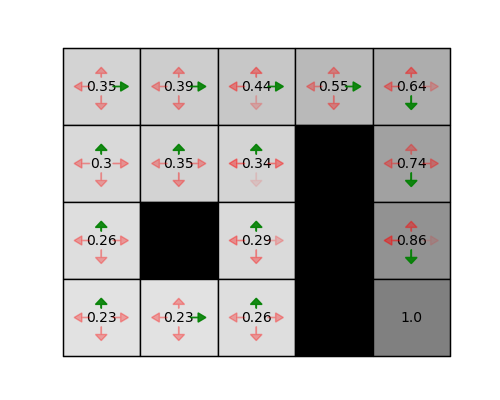

In [67]:
# visualize your results

%matplotlib notebook

m.new_render()
m.render(ac.critic.Q)

### Experiments

Play with the values of the hyper-parameters $alpha_1$ and $alpha_2$. Any idea how these hyper-parameters should be set with respect to each other?

## Critic based on the value function

The critic based on the action-value function can be replaced by a critic based on the value function without any change to the ActorCritic algorithm.

Try to do so below. Is it faster? Similar? Worse? In what case does it make a big difference?

In [70]:
"write the V-based critic class here"

class Critic():
    
    def __init__(self, mdp):
        self.V = np.zeros(mdp.observation_space.size)
    
    def __getitem__(self, state):
        return self.V[state]
    
    def __setitem__(self, state, value):
        self.V[state] = value
        


In [74]:
"write the resulting ActorCritic code here"
"write your ActorCritic code here"
class Agent():
    def __init__(self, mdp):
        self.mdp = mdp
        self.x = mdp.reset()
        
    def step(self, u):
        [y, r, done, info] = self.mdp.step(u)
        self.x = y
        return [y, r, done, info]
    
    def reset(self):
        self.x = self.mdp.reset()
    
class Actor():
    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy
    
    def getRandomAction(self):
        return np.random.randint(0, high=self.mdp.action_space.size, size=1)
    
    def followPolicy(self, state):
        return np.argmax(self.policy[state])
    
    def getAction(self, state, p=0.1):
        
        s = np.random.uniform()
        
        if s < p:
            return self.getRandomAction()
        
        return self.followPolicy(state)
    
class ActorCritic():
    
    def __init__(self, mdp, alpha_1, alpha_2):
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.mdp = mdp
        self.critic = Critic(mdp)
        self.agent = Agent(mdp)
        self.policy = StochasticPolicy(mdp)
        self.actor = Actor(mdp, self.policy)
        
    def run(self, nIteration=100000):
        for i in range(nIteration):
            x = self.agent.x
         
            u = self.actor.getAction(x)
                
            [y, r, done, info] = self.agent.step(u)
            
            if x in self.mdp.terminal_states:
                self.critic[x] = r
                self.agent.reset()
                continue
            
            delta = r + self.mdp.gamma * self.critic[y] - self.critic[x]
            self.critic[x] = self.critic[x]  + self.alpha_1 * delta
            self.policy[x][u] = self.policy[x][u]  + self.alpha_2 * delta
            
            self.policy.normalize(x)
            
        


In [75]:
"run the resulting ActorCritic code here"
"run your ActorCritic code here"
import import_ipynb
from my_mdp import maze_mdp # Markov Decision Process

from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

walls = [6, 13, 14, 15]
height = 4
width = 5
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

alpha_1 = 0.5
alpha_2 = 0.1

ac = ActorCritic(m, alpha_1, alpha_2)
ac.run()

<IPython.core.display.Javascript object>


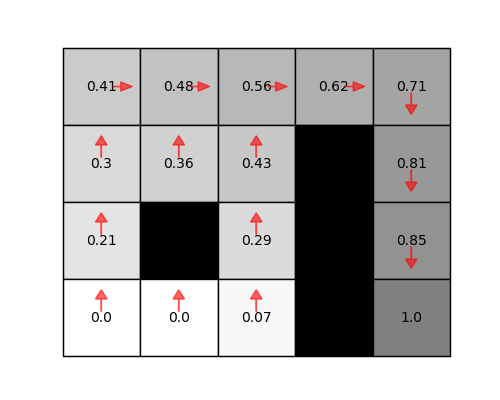

In [76]:
# visualize your results
%matplotlib notebook

m.new_render()
m.render(ac.critic.V, ac.policy.P.argmax(axis=1))